In [11]:
import pandas as pd
import numpy as np

In [12]:
def load_mask():
    print('loading mask...')
    rle_masks = pd.read_csv('../input/model_50A_slim_ensemble.csv')
    rle_masks = rle_masks[rle_masks['rle_mask'].isnull() == False]
    rle_masks.index = rle_masks['id']
    del rle_masks['id']
    rle_masks = rle_masks.to_dict('index')
    return rle_masks

In [13]:
rle_masks = load_mask()

loading mask...


In [14]:
rle_masks['039b1c58']

{'rle_mask': '17112 4 17301 23 17492 26 17684 31 17875 36 18067 38 18259 41 18452 42 18645 42 18838 43 19031 44 19225 44 19418 44 19612 43 19805 44 19998 45 20192 44 20384 46 20578 45 20771 45 20964 46 21157 46 21349 47 21542 47 21734 49 21927 49 22120 49 22312 50 22504 51 22697 51 22890 51 23082 52 23275 52 23467 53 23659 54 23851 55 24043 56 24236 56 24429 56 24621 57 24814 57 25006 58 25198 59 25389 61 25581 62 25772 64 25964 65 26157 65 26349 66 26541 67 26733 68 26925 69 27117 70 27309 72 27501 73 27694 73 27886 74 28078 75 28271 76 28464 76 28656 77 28848 79 29040 80 29233 81 29426 81 29618 83 29810 86 30002 87 30141 3 30194 89 30321 16 30386 90 30505 24 30579 90 30691 30 30772 91 30875 38 30964 92 31064 41 31156 93 31251 46 31348 141 31540 141 31732 141 31925 140 32117 140 32309 140 32502 139 32694 139 32887 138 33079 138 33272 137 33466 135 33658 135 33851 134 34043 134 34236 133 34429 132 34621 132 34814 131 35006 131 35199 130 35392 129 35584 129 35775 130 35966 131 36155 134

In [15]:
def do_length_decode(rle, H=192, W=384, fill_value=255):
    mask = np.zeros((H,W), np.uint8)
    if type(rle).__name__ == 'float': return mask
    mask = mask.reshape(-1)
    rle = np.array([int(s) for s in rle.split(' ')]).reshape(-1, 2)
    for r in rle:
        start = r[0]-1
        end = start + r[1]
        mask[start : end] = fill_value
    mask = mask.reshape(W, H).T   # H, W need to swap as transposing.
    return mask

In [16]:
name = '039b1c58'
mask = do_length_decode(rle_masks[name.split('.')[0]]['rle_mask'])

In [23]:
mask.shape

(192, 384)

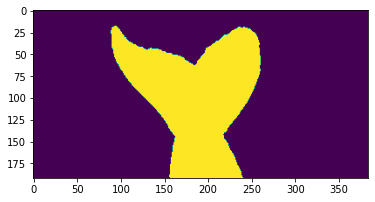

In [25]:
from matplotlib import pyplot as plt

plt.imshow(mask)
plt.show()